# Data Preparation Part 1 (10 points)


Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

## Library Imports

In [1]:
# Base Imports
import pandas as pd
import numpy as np 
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
%matplotlib inline

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Metrics and Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Train/ Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



## Load Data

In [2]:
df = pd.read_csv('../../../../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)

In [3]:
# %%time

# Convert age into years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

# re-encode gender to male (2) and female (0)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

# compute the body mass index based on weight and height
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

# create a BMI group
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

# bin blood pressure groups based on the api hi/ lo variables
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)



# Data Preparation Part 2 (5 points)


Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [4]:
# New Feature Model
X_cols = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Store feature matrix 
X = df_clean[X_cols] #.to_numpy()
# Store response vector
y = df_clean['cardio'] #.to_numpy()

# Full Model
# X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']


# Modeling and Evaluation 1 (10 points)


Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.



# Modeling and Evaluation 2 (10 points)

Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.




In [5]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = MultinomialNB()
clf2 = RandomForestClassifier(random_state=1)
clf3 = LogisticRegression(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 # ['rs', RobustScaler()],             <<< ValueError: Negative values in data passed to MultinomialNB (input X)
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])
                  
pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf3]])

clf_labels = ['Naive Bayes', 'Random Forest', 'Logistic Regression']

# Note n_jobs below. Setting it to -1 will create cv number of threads
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=2,
                             scoring='roc_auc',
                             n_jobs=-1)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.70 (+/- 0.00) [Naive Bayes]
ROC AUC: 0.75 (+/- 0.00) [Random Forest]
ROC AUC: 0.77 (+/- 0.00) [Logistic Regression]


# Modeling and Evaluation 3

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!


## Test Accuracy

In [6]:
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    fit = clf.fit(X_train, y_train)
    print("Test Accuracy: ",clf.score(X_test, y_test),"[%s]" % (label))

Test Accuracy:  0.6502572163475279 [Naive Bayes]
Test Accuracy:  0.7040583023721063 [Random Forest]
Test Accuracy:  0.7075593026579022 [Logistic Regression]


## Grid Search

In [33]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = MultinomialNB()
clf2 = RandomForestClassifier(random_state=1)
clf3 = LogisticRegression(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 # ['rs', RobustScaler()],             <<< ValueError: Negative values in data passed to MultinomialNB (input X)
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])
                  
pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf3]])

model_params = {
    "multinomialnb": {
        "model": pipe1,
        "params": {
            "clf__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]
        }
    },
    "randomforestclassifier": {
        "model": pipe2,
        "params": {
            "clf__n_estimators": [4, 6, 9],
            "clf__criterion": ['gini','entropy'],
            "clf__max_features": ['auto', 'sqrt', 'log2']
        }
    }
}

    # "multinomialnb": {
    #     "model": pipe1,
    #     "params": {
    #         "multinomialnb__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]
    #     }
    # }

    # "randomforestclassifier": {
    #     "model": pipe2,
    #     "params": {
    #         "randomforestclassifier__n_estimators": [4, 6, 9] #,
    #         "randomforestclassifier__criterion": ['gini','entropy'],
    #         "randomforestclassifier__max_features": ['auto', 'sqrt', 'log2']
    #     }
    # }

scores = []

for model_name, mp in model_params.items():
    start = time.time()
    clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=2, scoring="roc_auc", n_jobs=-1)
    # clf = GridSearchCV(estimator=mp["model"], param_grid=mp["params"], cv=2)
    clf.fit(X_train, y_train)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best ROC AUC": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time,
    "Best Estimator": clf.best_estimator_
    })

In [34]:
# Although not pretty, it's quick and easy to read
print('10 Fold Cross Validation Scores:')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'Best Estimator':
            print("Prediction Accuracy",': ',value.score(X_test, y_test))
        elif key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores:

Model :  multinomialnb
Best ROC AUC :  0.7028232669273226
Best Params :  {'clf__alpha': 1.0}
Mean Fit Time:  0.08347339630126953
Mean Score Time:  0.051782083511352536
Cross Validation Time :  0.5328240394592285
Prediction Accuracy :  0.6502572163475279

Model :  randomforestclassifier
Best ROC AUC :  0.7423931557844579
Best Params :  {'clf__criterion': 'entropy', 'clf__max_features': 'auto', 'clf__n_estimators': 9}
Mean Fit Time:  0.20770868990156385
Mean Score Time:  0.07292054096857707
Cross Validation Time :  3.1629600524902344
Prediction Accuracy :  0.7020577307802229


# Modeling and Evaluation 4 (10 Points)


Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.



# Modeling and Evaluation 5 (10 Points)


Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.




# Modeling and Evaluation 6 (10 Points)


Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


# Deployment (5 Points)


How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 


# Exceptional Work (10 points)


You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?


In [23]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


nb = MultinomialNB(alpha=10)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 # ['rs', RobustScaler()],
                 ['naivebayes', nb]])

fit = pipe1.fit(X_train, y_train)

precision    recall  f1-score   support

           0       0.66      0.63      0.64      7001
           1       0.65      0.67      0.66      6995

    accuracy                           0.65     13996
   macro avg       0.65      0.65      0.65     13996
weighted avg       0.65      0.65      0.65     13996



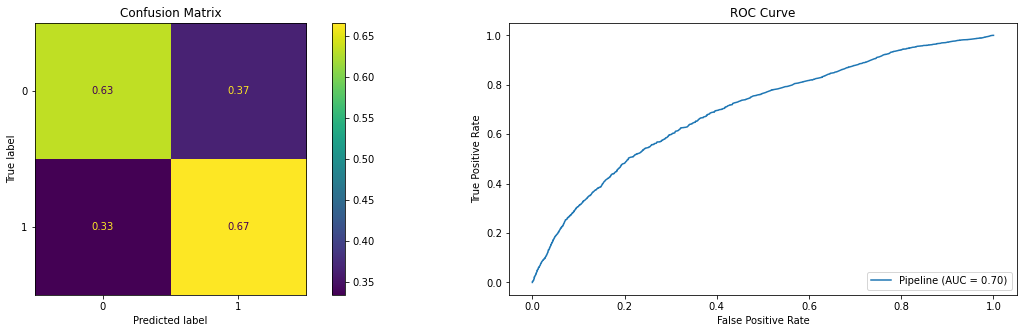

In [24]:
y_pred = fit.predict(X_test)
print(classification_report(y_test, y_pred))

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

# Pass Fitted Model, and our test sets, see how they do
plot_confusion_matrix(pipe1, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(pipe1, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()